# Подготовка модели распознавания рукописных букв и цифр

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchinfo import summary
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageOps

In [3]:
from torchvision.datasets import EMNIST
dataset = EMNIST('data/', 'balanced', download=False)

In [4]:
mapping = {}

with open('emnist-balanced-mapping.txt') as file:
    for row in file:
        i, j = map(int, row.strip().split())
        mapping[i] = chr(j)

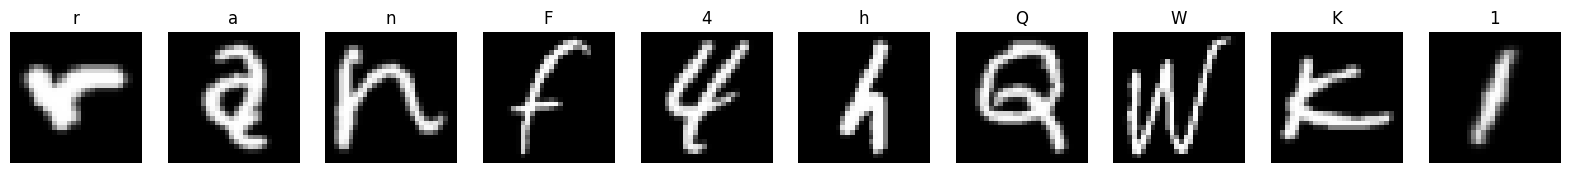

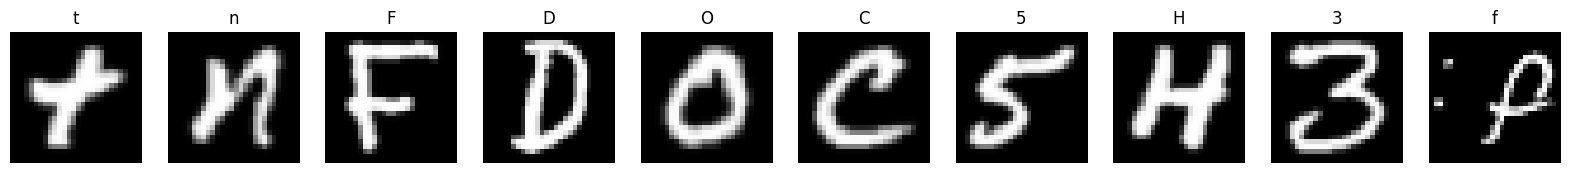

In [5]:
convert = lambda im: ImageOps.flip(im.rotate(90))

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(convert(dataset[i][0]), cmap='gray')
    axs[i].set_title(mapping[dataset[i][1]])
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(convert(dataset[i+10][0]), cmap='gray')
    axs[i].set_title(mapping[dataset[i+10][1]])
    axs[i].axis('off')
plt.show()

In [6]:
dataset[0][0].size

(28, 28)

## Prepare loaders

In [7]:
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]),
    # torch.Tensor.transpose
])

train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)

## Base CNN model
Используем свёртку с ядром 3 и 32 слоями, пулинг с ядром 2, и перцептрон с 1 скрытым слоем

In [55]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(in_features=6272, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )

    def forward(self, x):
        return self.model(x)

In [56]:
net = CNN(len(mapping))
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 47]                   --
├─Sequential: 1-1                        [1, 47]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Flatten: 2-4                      [1, 6272]                 --
│    └─Linear: 2-5                       [1, 64]                   401,472
│    └─ReLU: 2-6                         [1, 64]                   --
│    └─Linear: 2-7                       [1, 47]                   3,055
Total params: 404,847
Trainable params: 404,847
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.62
Estimated Total Size (MB): 1.82

### Train

In [221]:
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}')

        if epoch % val_fre == 0:
            validate(model, val_loader)
    print('\n')

def validate(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
    model.train()

Используем кросс-энтропийный лосс и оптимизатор SGD с learning rate 0.1

In [222]:
model = CNN(len(mapping))
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

n_epoch = 10
val_fre = 2

train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)

Epoch: 0
Iter: 0 	Loss: 3.8667845726013184
Iter: 10 	Loss: 2.984959125518799
Iter: 20 	Loss: 2.0194687843322754
Iter: 30 	Loss: 1.5359759330749512
Iter: 40 	Loss: 1.1391394138336182
Iter: 50 	Loss: 1.0530200004577637
Iter: 60 	Loss: 0.9110195636749268
Iter: 70 	Loss: 0.8288308382034302
Iter: 80 	Loss: 0.8026620745658875
Iter: 90 	Loss: 0.7601906061172485
Iter: 100 	Loss: 0.8759849071502686
Iter: 110 	Loss: 0.7909828424453735
Iter: 120 	Loss: 0.7567520141601562
Iter: 130 	Loss: 0.6296891570091248
Iter: 140 	Loss: 0.6328482627868652
Iter: 150 	Loss: 0.6587586998939514
Iter: 160 	Loss: 0.6439616680145264
Iter: 170 	Loss: 0.6268589496612549
Iter: 180 	Loss: 0.6323656439781189
Iter: 190 	Loss: 0.5875349044799805
Iter: 200 	Loss: 0.5821055173873901
Iter: 210 	Loss: 0.6128380298614502
Iter: 220 	Loss: 0.7039769291877747
Mean Train Loss: 0.999163
Val Loss: 0.633847 	Accuracy: 0.790904255319149
Epoch: 1
Iter: 0 	Loss: 0.5888924598693848
Iter: 10 	Loss: 0.5496308207511902
Iter: 20 	Loss: 0.52962

### Evaluate

In [223]:
print("Train Accuracy:")
validate(model, train_loader)

Train Accuracy:
Val Loss: 0.346149 	Accuracy: 0.8770921985815603


In [224]:
print("Test Accuracy:")
validate(model, val_loader)

Test Accuracy:
Val Loss: 0.415817 	Accuracy: 0.8581382978723404


In [225]:
d, t = next(iter(val_loader))
p = model(d).squeeze(1).argmax(dim=1, keepdim=True)

In [292]:
d.shape

torch.Size([500, 1, 28, 28])

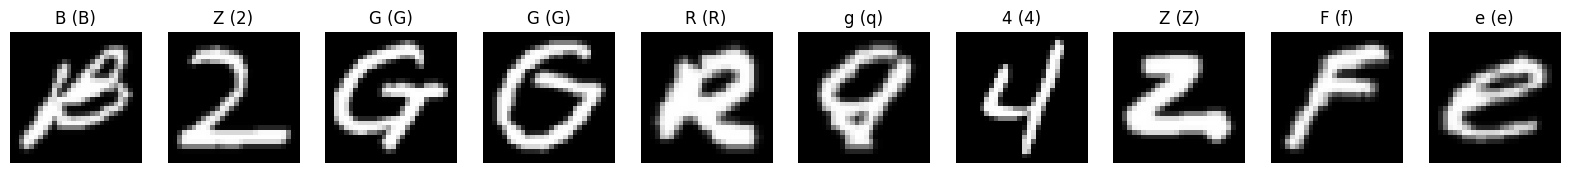

In [226]:
i = 0

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for data, target, pred in zip(d, t, p):
    if int(torch.randint(3, (1,))):
        continue
    axs[i].imshow(data[0].t(), cmap='gray')
    axs[i].set_title(f"{mapping[int(pred)]} ({mapping[int(target)]})")
    axs[i].axis('off')
    i += 1
    if i >= 10:
        break
plt.show()

### Heatmap
Посмотрим на распределение предсказанных и истинных значений, а также самые частые ошибки модели

In [227]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns

In [228]:
def predict_from_loader(model, loader):
    model.eval()
    pred = torch.Tensor()
    for data, _ in loader:
        with torch.no_grad():
            output = model(data).squeeze(1)
        pred = torch.cat((pred, output.argmax(dim=1, keepdim=True)))
    model.train()
    return pred.squeeze()

In [229]:
def true_from_loader(loader):
    true = torch.Tensor()
    for _, target in loader:
        true = torch.cat((true, target))
    return true.squeeze()

In [230]:
pred = predict_from_loader(model, val_loader)

In [231]:
true = true_from_loader(val_loader)

In [232]:
(pred == true).sum() / len(true)

tensor(0.8592)

In [233]:
pred = pred.numpy()
true = true.numpy()

ticks = [mapping[x] for x in np.unique(true)]

acc = accuracy_score(true, pred)
cm = pd.DataFrame(confusion_matrix(true, pred), ticks, ticks)

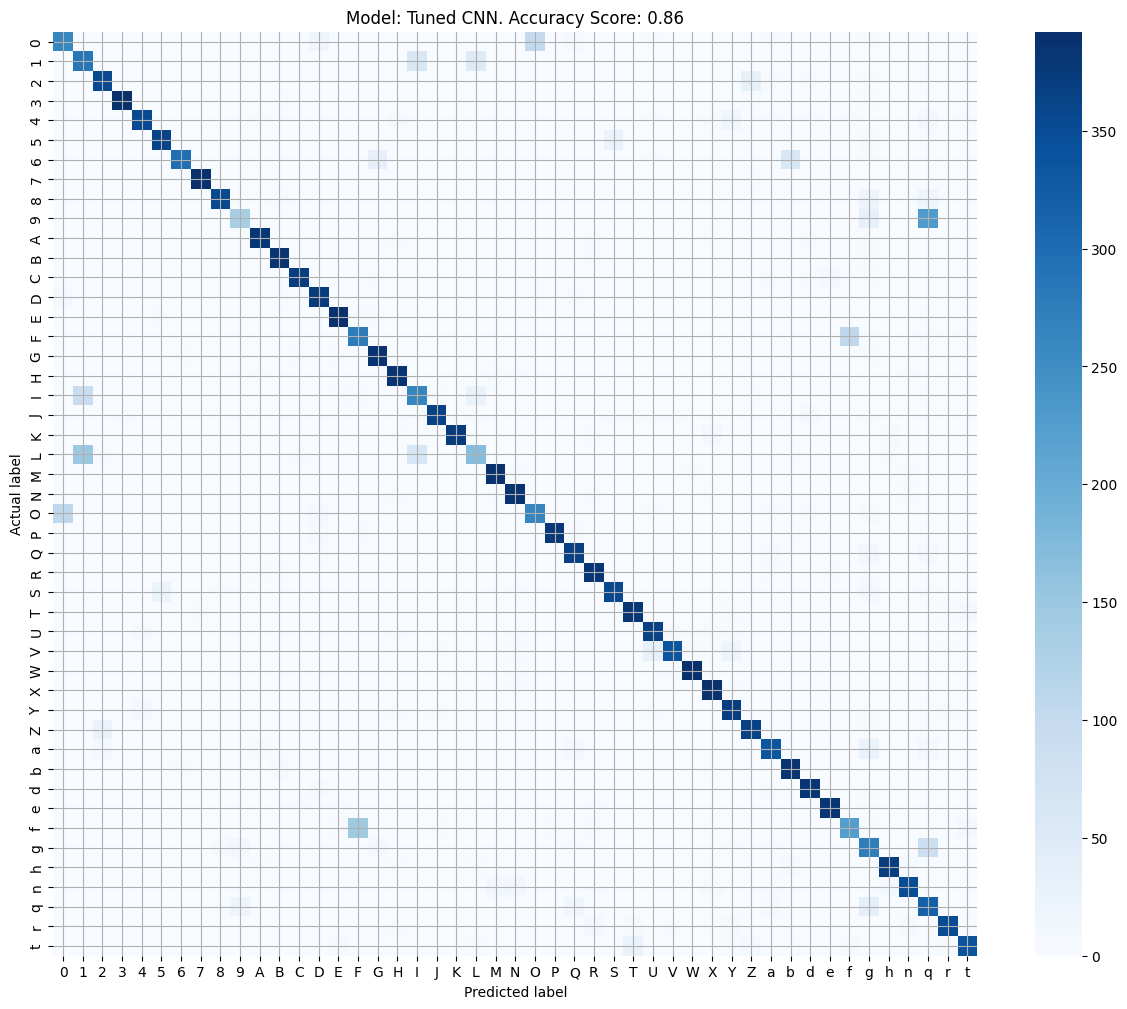

In [234]:
plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: Tuned CNN. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [235]:
print('Модель чаще всего ошибается в определении символа:')
mapping[cm.values.diagonal().argmin()]

Модель чаще всего ошибается в определении символа:


'9'

In [236]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
9 определяется как q


### Вывод

С базовым CNN удалось добиться точности 0,85. Попробуем усложнить модель и подобрать параметры

## Tuned model II

Для улучшения точности я внёс в модель следующие изменения:
* Размер батча уменьшил с 500 до 1000 - для уменьшения времени каждой итерации
* В качестве активации использовал GELU
* Перешёл на оптимизатор Adam с learning rate 0.01
* Ввёл вторую свёртку с 64 каналами
* Для уменьшения переобучения использовал Дроп-аут и Батч-нормализацию

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500)

In [257]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        
        self.model = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=n_classes)
        )

    def forward(self, x):
        return self.model(x)

In [258]:
net = CNN(len(mapping))
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 47]                   --
├─Sequential: 1-1                        [1, 47]                   --
│    └─Sequential: 2-1                   [1, 32, 14, 14]           --
│    │    └─Conv2d: 3-1                  [1, 32, 28, 28]           320
│    │    └─BatchNorm2d: 3-2             [1, 32, 28, 28]           64
│    │    └─GELU: 3-3                    [1, 32, 28, 28]           --
│    │    └─MaxPool2d: 3-4               [1, 32, 14, 14]           --
│    └─Sequential: 2-2                   [1, 64, 6, 6]             --
│    │    └─Conv2d: 3-5                  [1, 64, 12, 12]           18,496
│    │    └─BatchNorm2d: 3-6             [1, 64, 12, 12]           128
│    │    └─GELU: 3-7                    [1, 64, 12, 12]           --
│    │    └─MaxPool2d: 3-8               [1, 64, 6, 6]             --
│    └─Flatten: 2-3                      [1, 2304]                 --
│    └─Li

### Train the tuned model

In [259]:
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}')

        if epoch % val_fre == 0:
            validate(model, val_loader)
        
        print()

def validate(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
    model.train()

In [260]:
model = CNN(len(mapping))
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

n_epoch = 8
val_freq = 1

train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_freq)

validate(model, val_loader)

Epoch: 0
iter: 0 	Loss: 3.935817003250122
iter: 10 	Loss: 7.858759880065918
iter: 20 	Loss: 2.4120256900787354
iter: 30 	Loss: 1.5008782148361206
iter: 40 	Loss: 1.2167930603027344
iter: 50 	Loss: 1.0124379396438599
iter: 60 	Loss: 0.8034401535987854
iter: 70 	Loss: 0.7651459574699402
iter: 80 	Loss: 0.7832311987876892
iter: 90 	Loss: 0.7107664942741394
iter: 100 	Loss: 0.6575372815132141
iter: 110 	Loss: 0.6532723903656006
iter: 120 	Loss: 0.6440204381942749
iter: 130 	Loss: 0.7223607301712036
iter: 140 	Loss: 0.6079059839248657
iter: 150 	Loss: 0.5830143690109253
iter: 160 	Loss: 0.6484098434448242
iter: 170 	Loss: 0.5208590626716614
iter: 180 	Loss: 0.5469889640808105
iter: 190 	Loss: 0.5353359580039978
iter: 200 	Loss: 0.5681203007698059
iter: 210 	Loss: 0.5187190175056458
iter: 220 	Loss: 0.565278947353363
Mean Train Loss: 1.435504
Val Loss: 0.507801 	Accuracy: 0.8347872340425532

Epoch: 1
iter: 0 	Loss: 0.587935745716095
iter: 10 	Loss: 0.5035606622695923
iter: 20 	Loss: 0.507933

сделаем ещё несколько эпох обучения с learning rate 0.001

In [261]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 5
val_freq = 1

train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_freq)

Epoch: 0
iter: 0 	Loss: 0.2945024371147156
iter: 10 	Loss: 0.3027791380882263
iter: 20 	Loss: 0.23978029191493988
iter: 30 	Loss: 0.22732092440128326
iter: 40 	Loss: 0.2791692614555359
iter: 50 	Loss: 0.2559893727302551
iter: 60 	Loss: 0.20908299088478088
iter: 70 	Loss: 0.18521328270435333
iter: 80 	Loss: 0.2988392114639282
iter: 90 	Loss: 0.2936801314353943
iter: 100 	Loss: 0.2913942039012909
iter: 110 	Loss: 0.29061681032180786
iter: 120 	Loss: 0.24339522421360016
iter: 130 	Loss: 0.2384866178035736
iter: 140 	Loss: 0.2794311046600342
iter: 150 	Loss: 0.22755266726016998
iter: 160 	Loss: 0.24128390848636627
iter: 170 	Loss: 0.2703244686126709
iter: 180 	Loss: 0.2404664009809494
iter: 190 	Loss: 0.20669247210025787
iter: 200 	Loss: 0.29140084981918335
iter: 210 	Loss: 0.2226969450712204
iter: 220 	Loss: 0.26833173632621765
Mean Train Loss: 0.258468
Val Loss: 0.342176 	Accuracy: 0.8845212765957446

Epoch: 1
iter: 0 	Loss: 0.2590998411178589
iter: 10 	Loss: 0.17966990172863007
iter: 20

Сохраним модель для дальнейшего использования

In [296]:
torch.save(model.state_dict(), 'checkpoints/cnn.pth')

TypeError: save() got an unexpected keyword argument 'weights_only'

### Evaluate Tuned

In [263]:
print("Train Accuracy:")
validate(model, train_loader)

Train Accuracy:
Val Loss: 0.179577 	Accuracy: 0.9293705673758865


In [264]:
print("Test Accuracy:")
validate(model, val_loader)

Test Accuracy:
Val Loss: 0.360344 	Accuracy: 0.881968085106383


In [265]:
it = iter(val_loader)
d, t = next(it)
p = model(d).squeeze(1).argmax(dim=1, keepdim=True)

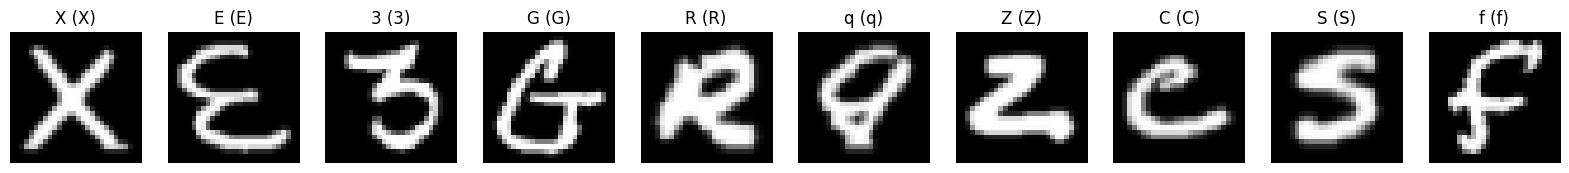

In [266]:
i = 0

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for data, target, pred in zip(d, t, p):
    if int(torch.randint(3, (1,))):
        continue
    axs[i].imshow(data[0].t(), cmap='gray')
    axs[i].set_title(f"{mapping[int(pred)]} ({mapping[int(target)]})")
    axs[i].axis('off')
    i += 1
    if i >= 10:
        break
plt.show()

In [267]:
d, t = next(it)
p = model(d).squeeze(1).argmax(dim=1, keepdim=True)

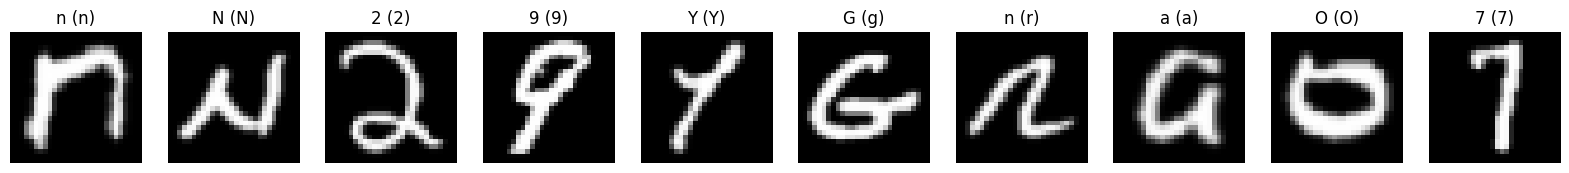

In [268]:
i = 0

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for data, target, pred in zip(d, t, p):
    if int(torch.randint(3, (1,))):
        continue
    axs[i].imshow(data[0].t(), cmap='gray')
    axs[i].set_title(f"{mapping[int(pred)]} ({mapping[int(target)]})")
    axs[i].axis('off')
    i += 1
    if i >= 10:
        break
plt.show()

### Heatmap
Посмотрим на распределение предсказанных и истинных значений, а также самые частые ошибки модели

In [269]:
pred = predict_from_loader(model, val_loader)

In [270]:
true = true_from_loader(val_loader)

In [271]:
(pred == true).sum() / len(true)

tensor(0.8817)

In [272]:
pred = pred.numpy()
true = true.numpy()

ticks = [mapping[x] for x in np.unique(true)]

acc = accuracy_score(true, pred)
cm = pd.DataFrame(confusion_matrix(true, pred), ticks, ticks)

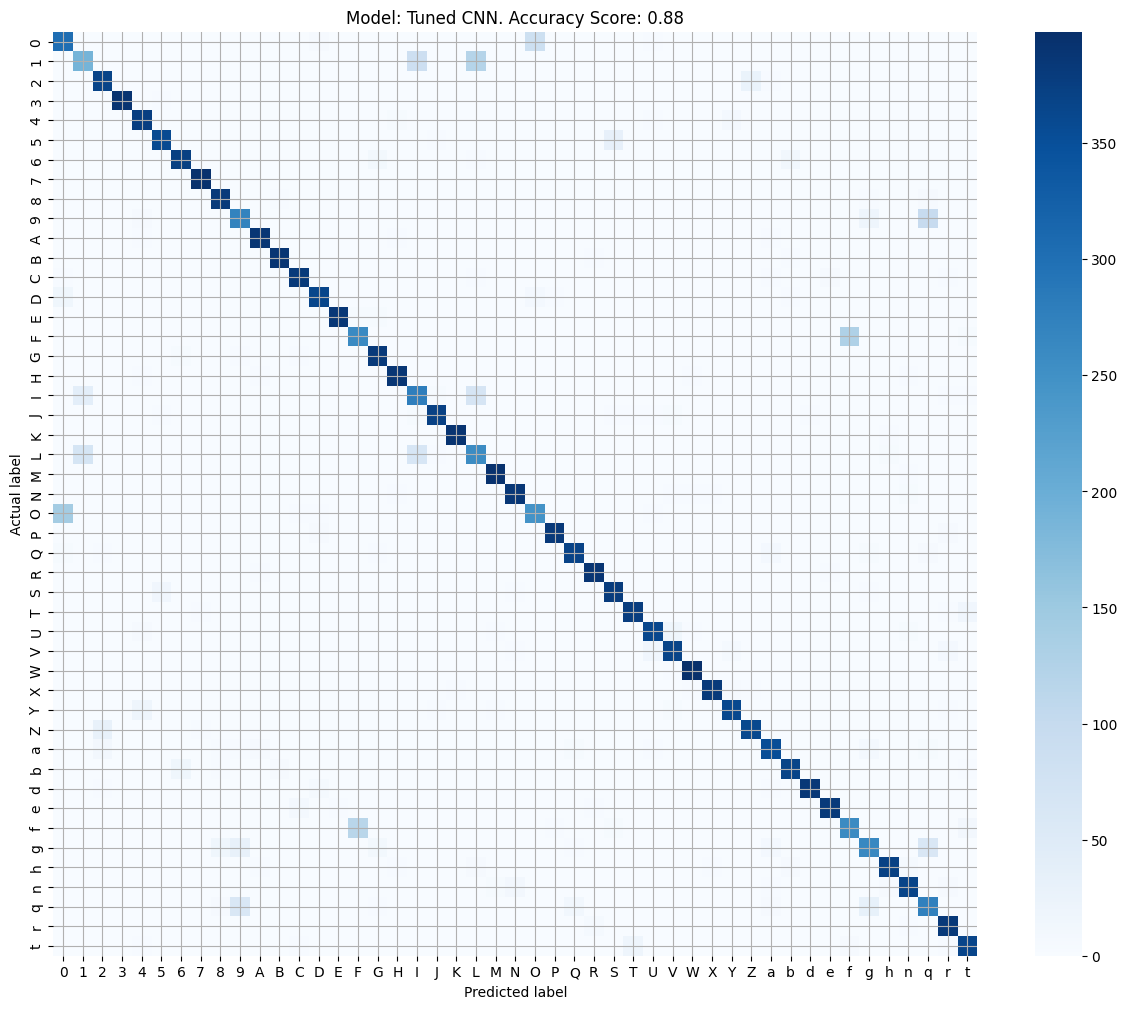

In [273]:
plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: Tuned CNN. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [274]:
print('Модель чаще всего ошибается в определении символа:')
mapping[cm.values.diagonal().argmin()]

Модель чаще всего ошибается в определении символа:


'1'

In [275]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
O определяется как 0


## Dump to pkl

In [285]:
from datetime import datetime
import os
import pickle

In [290]:
result = {
    'model path': 'checkpoints/cnn.pth',
    'type': model.__class__.__name__,
    'accuracy': acc,
    'char map dict': mapping,
    'timestamp': datetime.now().isoformat(),
    'info': 'EMNIST CV recognantion model',
    'author': 'Arseniy Kubanov',
}

In [291]:
with open(os.path.join('myapp', 'model.pkl'),'wb') as f:
    pickle.dump(result, f)

In [294]:
with open(os.path.join('data', 'test_tensor.pkl'),'wb') as f:
    pickle.dump(d, f)

## Выводы

Создана модель, распознающая рукописные символы EMNIST с точность 0,88 на валидационной выборке